In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-poster")
%matplotlib inline

# Stability of Numerical Solutions
We define $E_t$ as the **local truncation error**. A solution is said to be unstable if $E_t$ grows in an unbound fashion.

Three factors affect stability:
* The differential equation being solved.
* The numerical method being used.
* The step size $h$.

For the differential equation itself, we can check if it is **ill-conditioned** if it has an analytical solution.
If the value to estimate is $y$, we say that the equations is inherently stable as long as $y\rightarrow 0$ when $t\rightarrow \infty$.

---
If no analytical solution is available, we can check how the estimated $y_{i+1}$ behaves.
Note that **this value depends on all three factors**.
As long as
\begin{equation}
    \Big{|}\frac{y_{i+1}}{y_i}\Big{|} < 1,
\end{equation}
then the differential equation-estimation method-step size combination is stable, or is said to have a **decaying solution**.

Since we cannot change the differential equation, we are looking into smart **estimation method** and **step size** combinations.

---
Some notes to keep in mind:
* High stability *does not entail* high accuracy, it just means that reducing the step size actually increases accuracy.
* Oscillations are an indicator of instability, usually meaning that the step size is too large.

# $\frac{dy}{dt} = -\lambda y$

In [2]:
def explicit_euler(dydt, h, t_i, y_i):
    return y_i + h*dydt(t_i, y_i)

def rk4(dydt, h, t_i, y_i):
    k1 = dydt(t_i,       y_i)
    k2 = dydt(t_i + h/2, y_i + k1*h/2)
    k3 = dydt(t_i + h/2, y_i + k2*h/2)
    k4 = dydt(t_i + h,   y_i + k3*h)
    return y_i + (k1/6 + k2/3 + k3/3 + k4/6)*h

def abm4(dydt, dydt_2, dydt_1, dydt_0, h, t_3, y_2):
    y_3 = y_2 + h*((23/12)*dydt_2 - (16/12)*dydt_1 + (5/12)*dydt_0) # "Fake" y_3 using AB4.
    return y_2 + h*((9/24)*dydt(t_3, y_3) + (19/24)*dydt_2 - (5/24)*dydt_1 + (1/24)*dydt_0) # "Real" y_3 using AM4.

## Stability computation

In [3]:
from sympy import *
init_printing()
t_i, y_i, y_0 = symbols("t_i y_i y_0", real=True)
a, h = symbols("\lambda h", real=True, positive=True)
dfdt = lambda t, y:  -a*y

In [4]:
# Explicit euler.
y_next = explicit_euler(dfdt, h, t_i, y_i)
expr = simplify(Abs(y_next/y_i) - 1)
solve(expr, h)

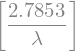

In [5]:
# RK4.
y_next = rk4(dfdt, h, t_i, y_i)
expr = simplify(Abs(y_next/y_i) - 1)
# expr_sol = solve(expr, h)
[2.7853/a] # Solved in Wolfram + by hand.

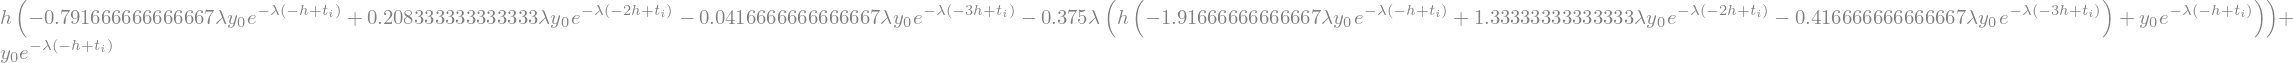

In [6]:
# ABM4.
# TODO.
f    = lambda t, y0: y0*exp(-a*t)
y_next = abm4(dfdt, dfdt(t_i-h, f(t_i-h, y_0)), dfdt(t_i-2*h, f(t_i-2*h, y_0)), dfdt(t_i-3*h, f(t_i-3*h, y_0)), \
              h, t_i, f(t_i-h, y_0))
y_next

## Step size comparison ($\lambda = 4$, $y_0 = 16$)
$E_t = 0.5$.

In [7]:
# ODE to solve: dy/dt = -4y
a = 4
dfdt = lambda t, y: -a*y

In [8]:
def euler_plt(h, y0, tmax):
    t = np.arange(0, tmax+h, h)
    y = np.zeros(len(t))
    y[0] = y0
    for i in range(1, len(t)):
        y[i] = explicit_euler(dfdt, h, t[i-1], y[i-1])

    plt.figure(figsize = (20, 8))
    plt.plot(t, y0*np.exp(-a*t), 'g', label="Exact Solution")
    plt.plot(t, y,               'b', label="Explicit Euler (h = " + str(h) + ")")
    plt.xlabel("t (h = " + str(h) + ")")
    plt.ylabel("y(t)")
    plt.grid()
    plt.legend(loc="upper right")
    plt.show()

In [9]:
y0   = 16
tmax = 4

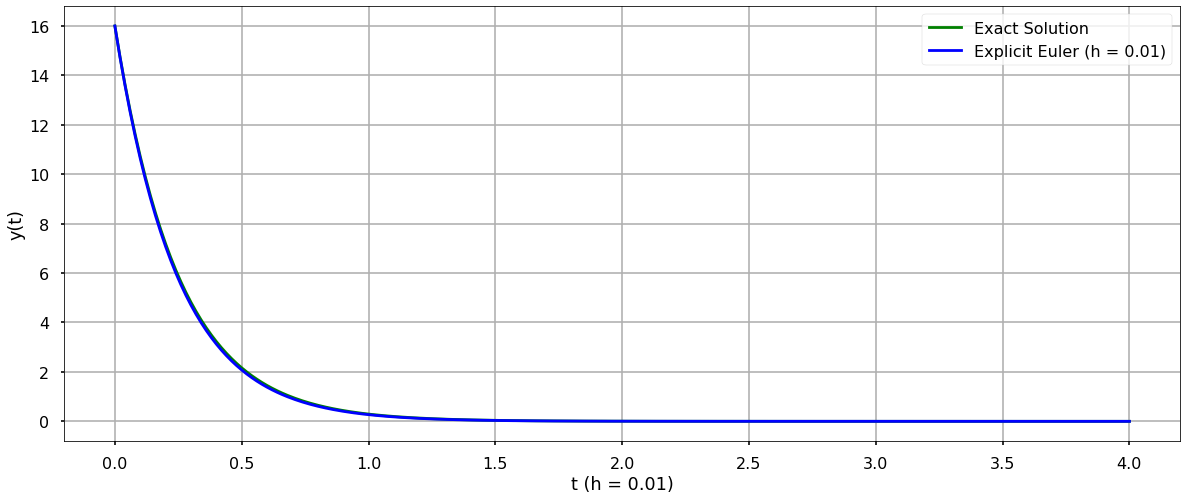

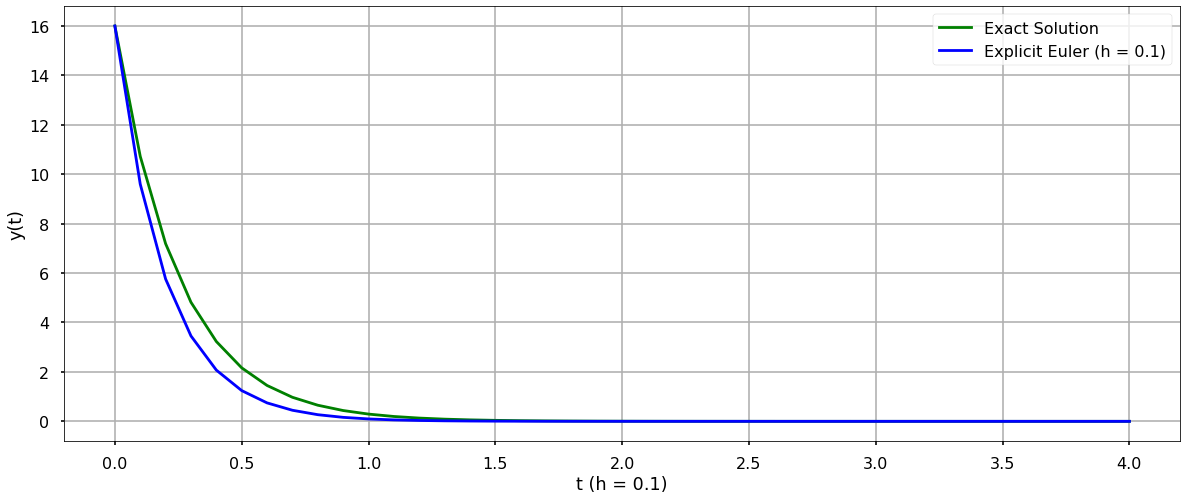

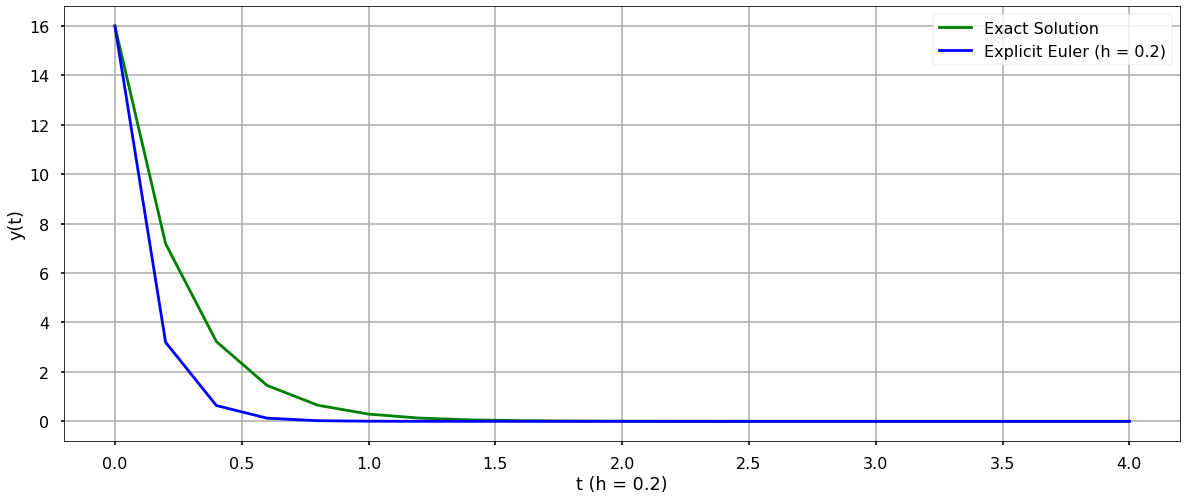

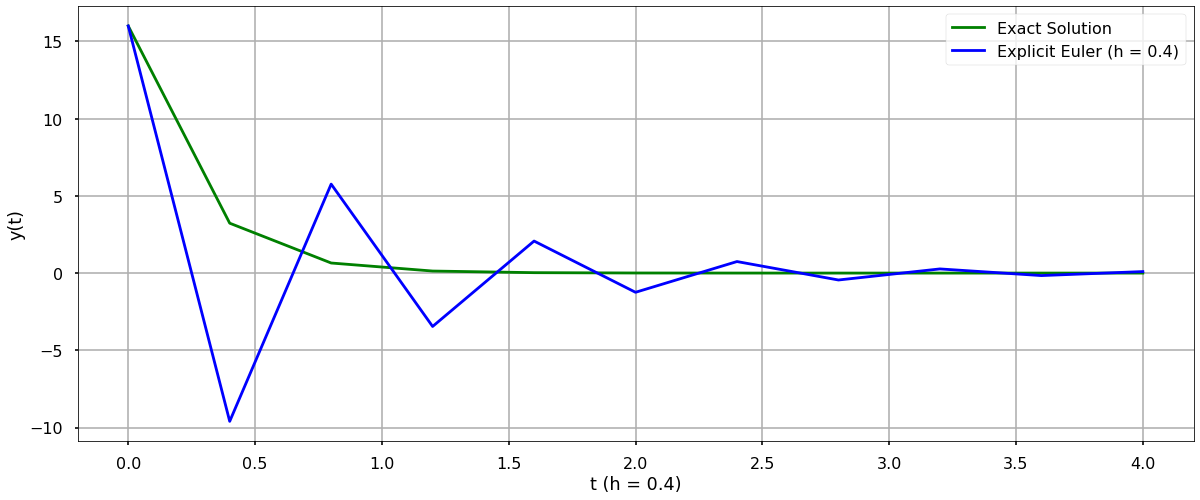

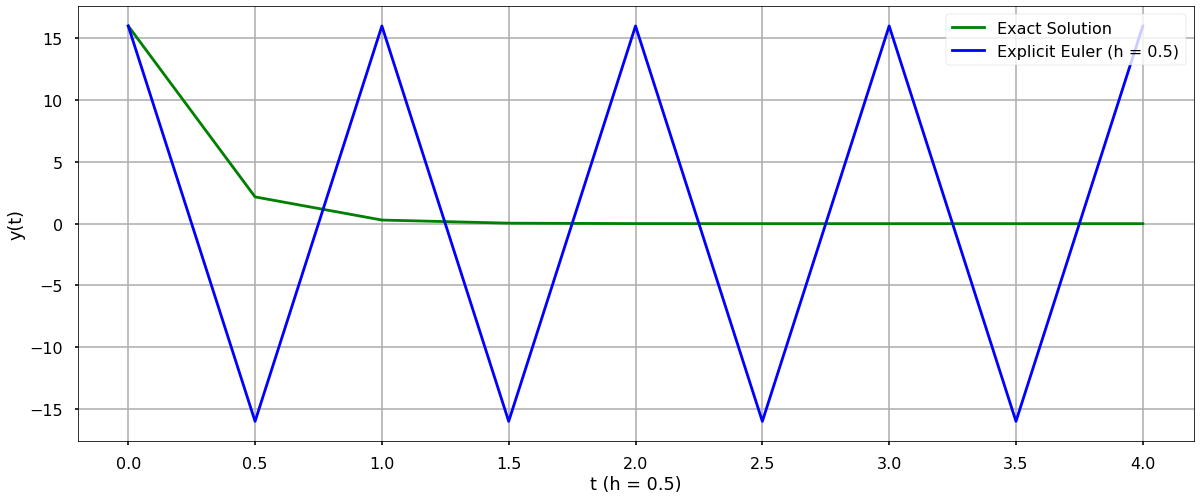

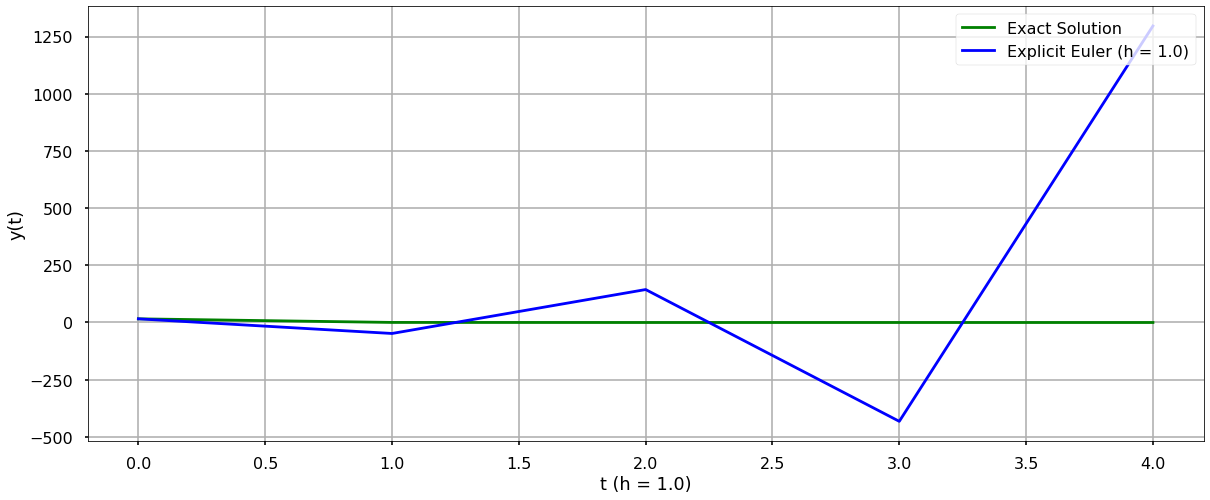

In [10]:
euler_plt(0.01, y0, tmax)
euler_plt(0.1,  y0, tmax)
euler_plt(0.2,  y0, tmax)
euler_plt(0.4,  y0, tmax)
euler_plt(0.5,  y0, tmax)
euler_plt(1.0,  y0, tmax)

## Method comparison ($\lambda = 4$, $y_0 = 16$)
* Explicit euler: $E_t = 0.5$.
* RK4: $E_t \approx 0.7$.
* ABM4: TODO.

In [11]:
def y_init(t, y0):
    y    = np.zeros(len(t))
    y[0] = y0
    return y

def euler_comparison(h, t, y0):
    y = y_init(t, y0)
    for i in range(1, len(t)):
        y[i] = explicit_euler(dfdt, h, t[i-1], y[i-1])
    return y

def rk4_comparison(h, t, y0):
    y = y_init(t, y0)
    for i in range(1, len(t)):
        y[i] = rk4(dfdt, h, t[i-1], y[i-1])
    return y

def abm4_comparison(h, t, y0):
    y    = y_init(t, y0)
    dydt = y_init(t, dfdt(t[0], y[0]))
    for i in range(1, 3): # First 2 iterations done in RK4.
        y[i]    = rk4(dfdt, h, t[i-1], y[i-1])
        dydt[i] = dfdt(t[i], y[i]) # Store relevant derivatives to avoid re-computing.

    for i in range(3, len(t)): # Following iterations done in ABM4.
        y[i]    = abm4(dfdt, dydt[i-1], dydt[i-2], dydt[i-3], h, t[i], y[i-1])
        dydt[i] = dfdt(t[i], y[i])

    return y

def method_comparison(h, y0, tmax):
    t = np.arange(0, tmax+h, h)

    y_euler = euler_comparison(h, t, y0) # Explicit (forward) euler.
    y_rk4   = rk4_comparison(  h, t, y0) # Runge Kutta 4.
    y_abm4  = abm4_comparison( h, t, y0) # Adams-Bashforth-Moulton 4.

    plt.figure(figsize = (20, 8))
    plt.plot(t, y0*np.exp(-a*t), 'g', label="Exact Solution")
    if (h < 0.5): plt.plot(t, y_euler,         'b', label="Explicit Euler")
    plt.plot(t, y_rk4,           'r', label="4th order Runge-Kutta")
    plt.plot(t, y_abm4,          'y', label="4th order Adams-Bashforth-Moulton")
    plt.xlabel("t (h = " + str(h) + ")")
    plt.ylabel("y(t)")
    plt.grid()
    plt.legend(loc="upper right")
    plt.show()

In [12]:
y0   = 16
tmax = 4

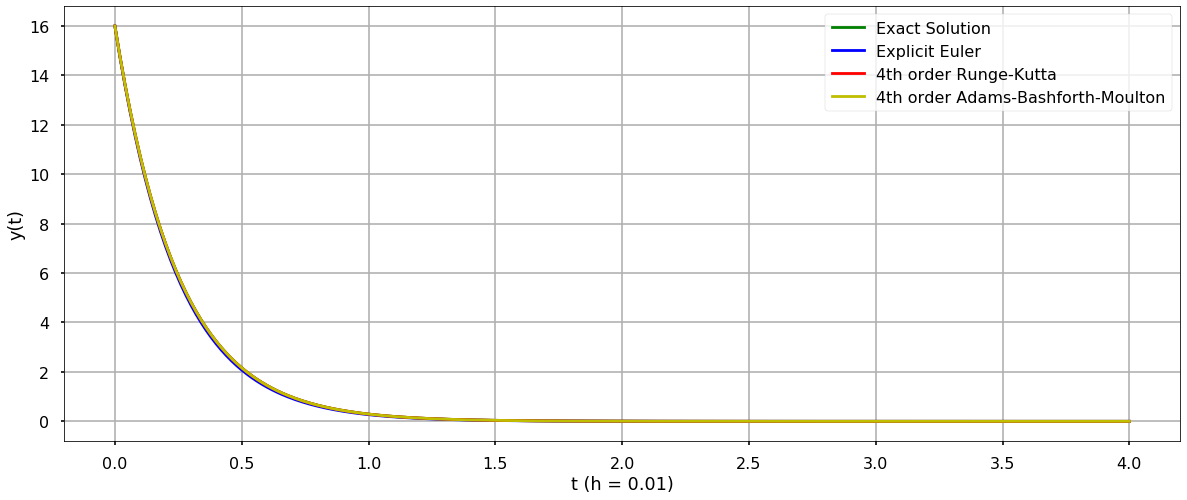

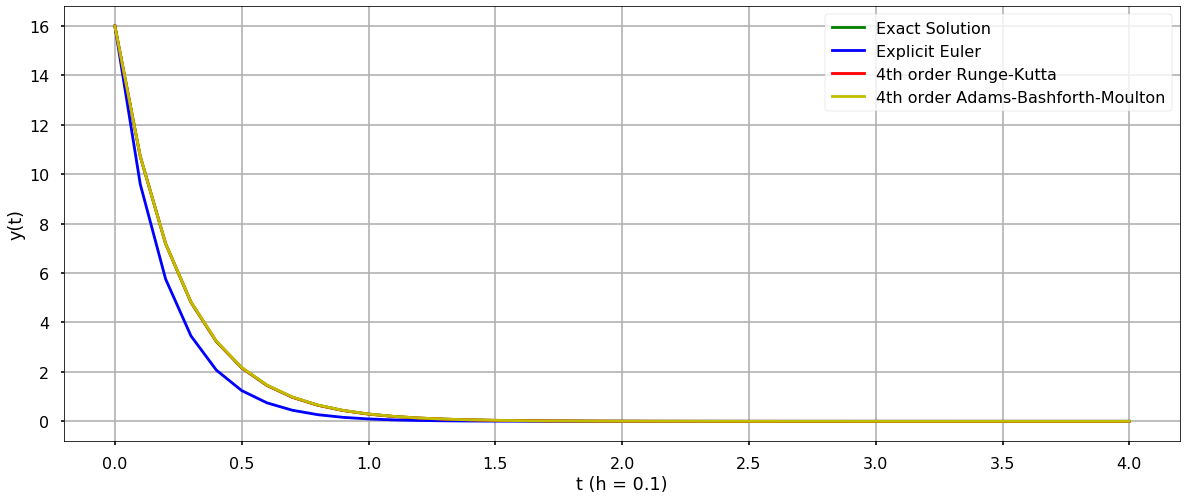

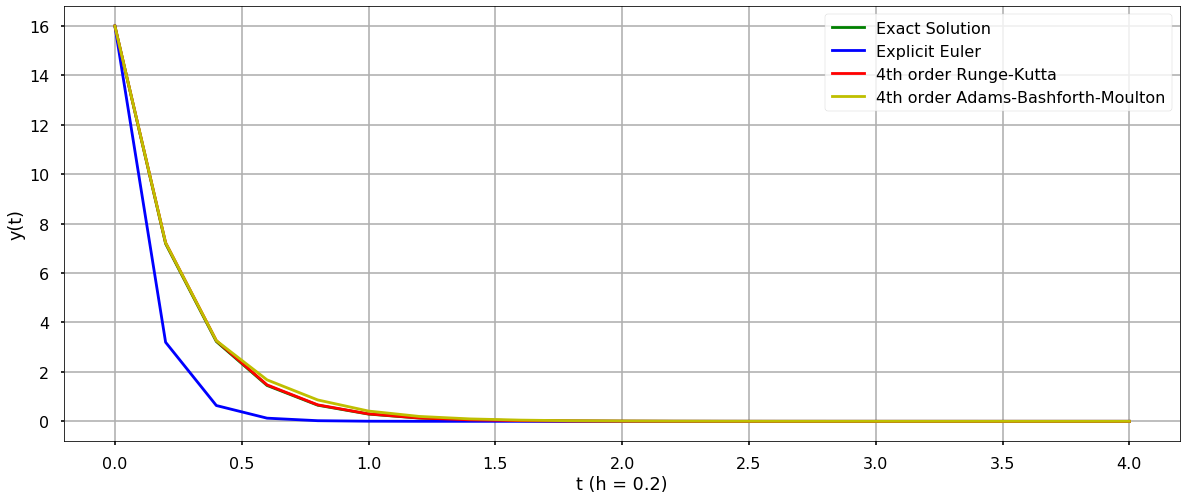

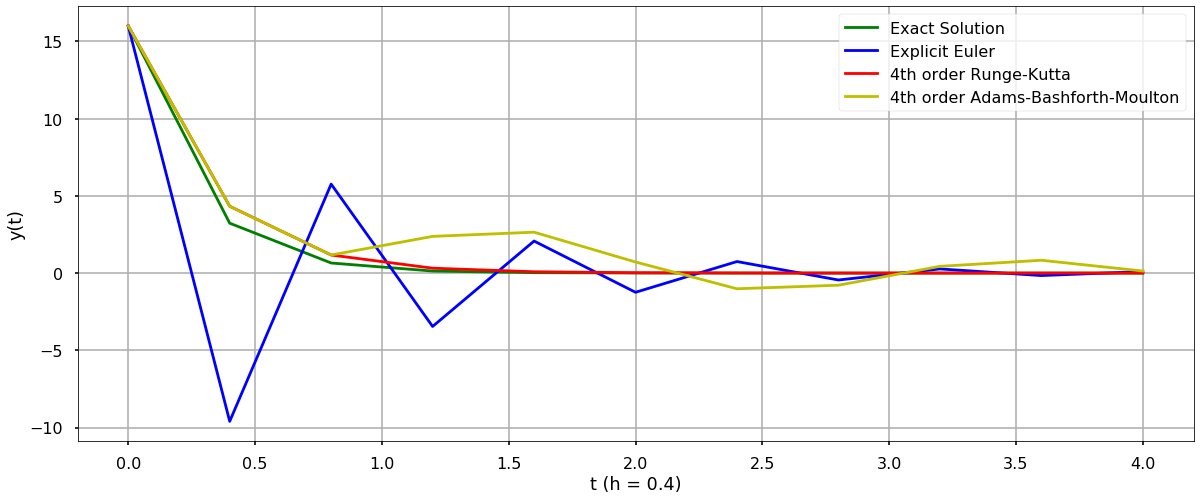

(We remove Euler from this point onward for clarity)


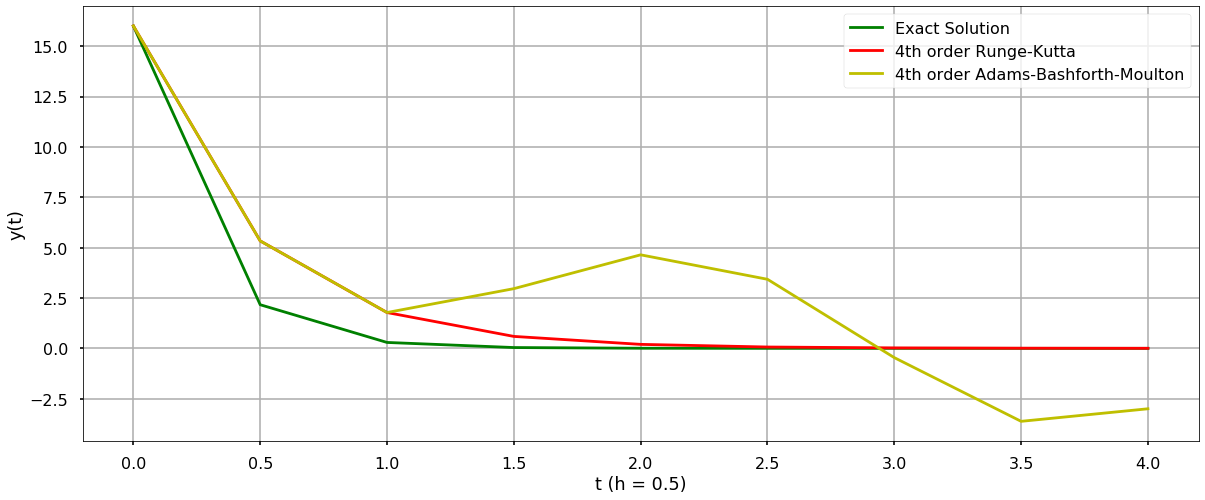

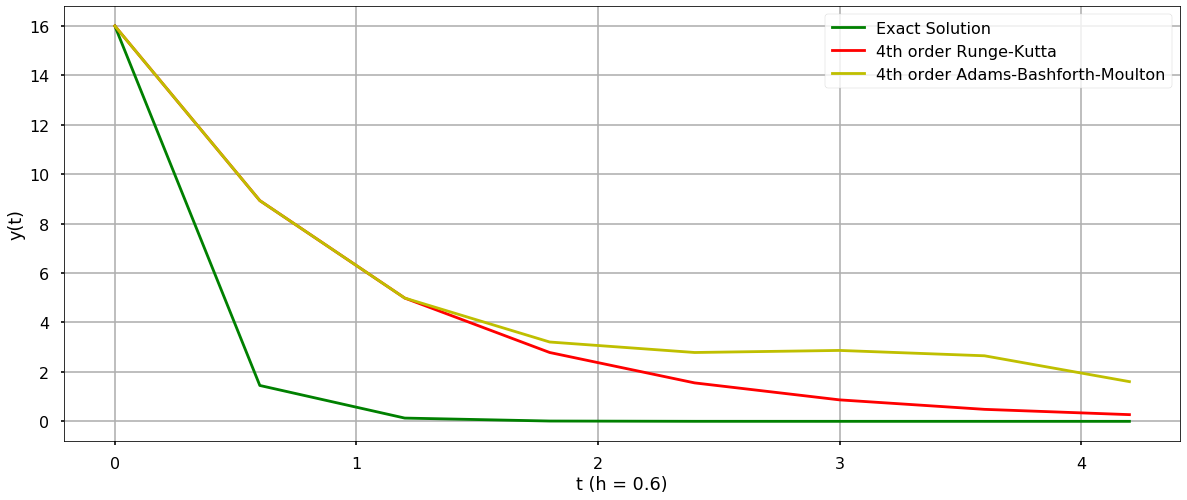

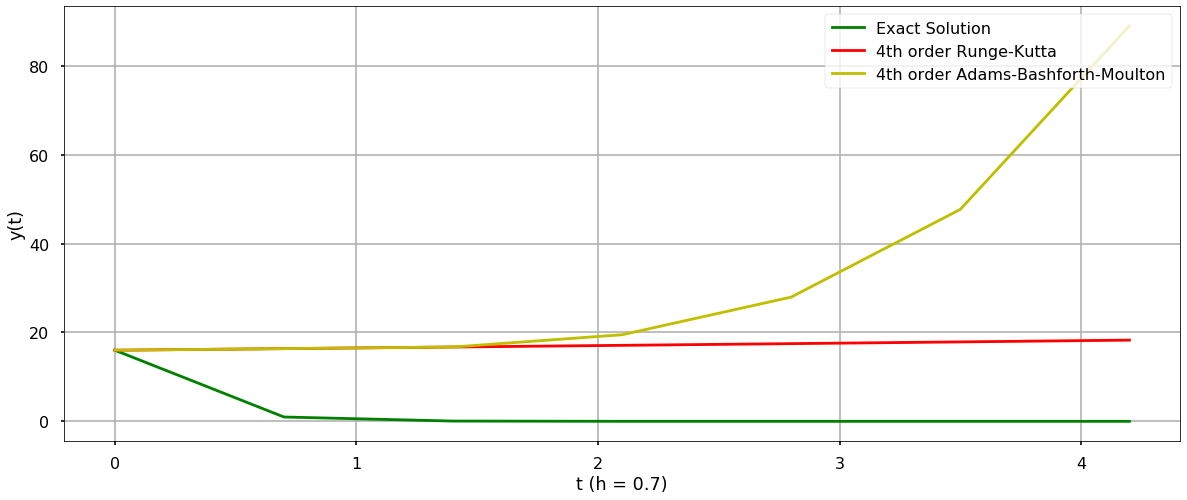

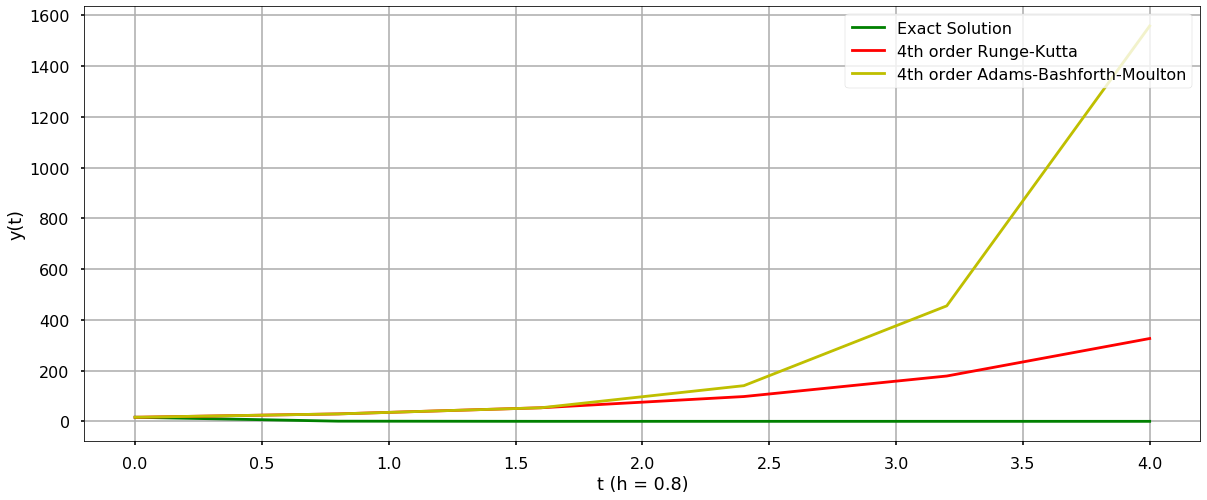

In [13]:
method_comparison(0.01, y0, tmax)
method_comparison(0.1,  y0, tmax)
method_comparison(0.2,  y0, tmax)
method_comparison(0.4,  y0, tmax)
print("(We remove Euler from this point onward for clarity)")
method_comparison(0.5,  y0, tmax)
method_comparison(0.6,  y0, tmax)
method_comparison(0.7,  y0, tmax)
method_comparison(0.8,  y0, tmax)